<a target="_blank" href="https://colab.research.google.com/github/lucaase/LFP-analysis-HS/blob/main/Course-Notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a target="_blank" href="https://www.kaggle.com/kernels/welcome?src=https://github.com/lucaase/LFP-analysis-HS/blob/main/Course-Notebook.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/>
</a>

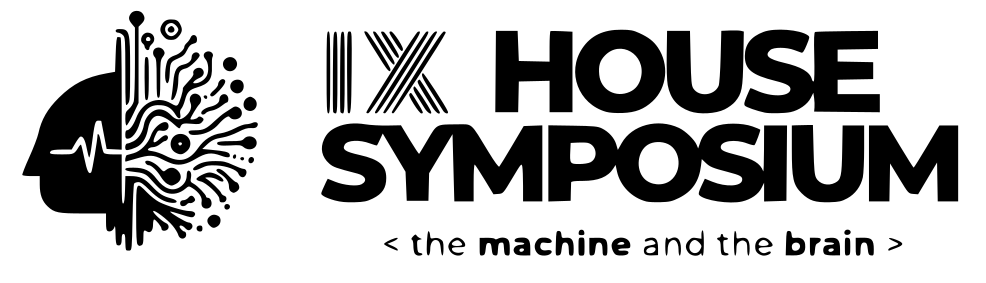

# **Decodificando o cérebro por meio do aprendizado de máquina**

Bem vindos à nona edição do House Symposium do Instituto do Cérebro! Como parte do evento, esse workshop oferecerá teoria e prática em técnicas de aprendizado de máquina para análise de dados eletrofisiológicos neurais. Os participantes serão apresentados a métodos de redução de dimensionalidade, clusterização e classificação, aplicados na identificação de padrões latentes em dados de alta dimensionalidade.

**Instituto do Cérebro, Universidade Federal do Rio Grande do Norte**

**Tutores**: Lucas CS Tavares (lucastavares@neuro.ufrn.br), Rodrigo MM Santiago (rsantiago@neuro.ufrn.br)

___
# Objetivos do Workshop

*Tempo estimado do tutorial: 2 horas*

Neste tutorial interativo, nossos principais objetivos são capacitar os participantes a explorar e interpretar dados neurais e comportamentais utilizando métodos de aprendizado de máquina. Ao longo da sessão, os participantes praticarão as seguintes áreas:

- **Carregamento e Visualização de Dados**:
    - Aprenda a carregar e visualizar dados neurais (LFPs e spikes) e comportamentais (contínuos e categóricos, binários e multiclasse).
    - Realize uma análise estatística inicial, avaliando o balanceamento de classes, dispersão e medidas centrais nos dados.

- **Redução de Dimensionalidade**:
    - Descubra técnicas como PCA, UMAP e CEBRA, entendendo como essas ferramentas transformam dados em representações compactas.
    - Explore a aplicação de aprendizado supervisionado e não supervisionado, incluindo abordagens de clustering.

- **Regressão**:
    - Aprofunde-se em modelos como Regressão Linear, SVMs e Redes Neurais para predizer variáveis contínuas.
    - Veja exemplos práticos, como prever posição a partir de sinais do hipocampo.
    - Entenda o impacto do pré-processamento e da limpeza de dados nas predições.

- **Classificação**:
    - Explore métodos como Regressão Logística, KNN e Redes Neurais para classificar dados categóricos.
    - Trabalhe com dados do projeto IBL, identificando fatores de confusão e avaliando a seleção de dados.

- **Avaliação de Modelos**:
    - Identifique armadilhas comuns em modelos de aprendizado de máquina.
    - Entenda as métricas de desempenho mais utilizadas e saiba quando usar cada uma.
    - Aprenda a interpretar trade-offs de desempenho e visualizar resultados através de gráficos.

<br>

**Créditos:**

- O formato deste notebook foi inspirado nos exemplos da [Neuromatch Academy](https://academy.neuromatch.io).

## Instalação de Pacotes

In [ ]:
!pip install umap-learn
!pip install 'cebra[dev,demos]'

## Importação de Pacotes

In [39]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA
from sklearn.decomposition import PCA

from matplotlib.collections import LineCollection
import pandas as pd

# Carregamento e Visualização de Dados

Nesta seção, vamos explorar o carregamento de dados neurais e comportamentais, seguido pela visualização inicial para compreender as características principais. Usaremos dados sintéticos que simulam padrões comuns em experimentos neurocientíficos, incluindo potenciais de ação (spikes), sinais contínuos (comportamentos locomotores) e variáveis discretas (estados comportamentais).

## Carregando Dados

Começaremos carregando dois tipos principais de dados:

1. **Dados Neurais (Spikes e LFP):**
   - Potenciais de ação registrados de múltiplos neurônios.

2. **Dados Comportamentais:**
   - Variável contínua: velocidade do animal ao longo do tempo.
   - Variáveis discretas: estados comportamentais como "parado" (0), "caminhando" (1) e "correndo" (2).

In [ ]:
# Carregar o dataset
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

# hippocampus_pos.neural  # Dados de atividade neural
# hippocampus_pos.pos     # Dados de posição

## Visualização de Dados
### Visualizando Spikes
Os spikes são eventos binários (0 ou 1) associados à atividade dos neurônios ao longo do tempo. Vamos construir um gráfico raster para exibir sua distribuição.

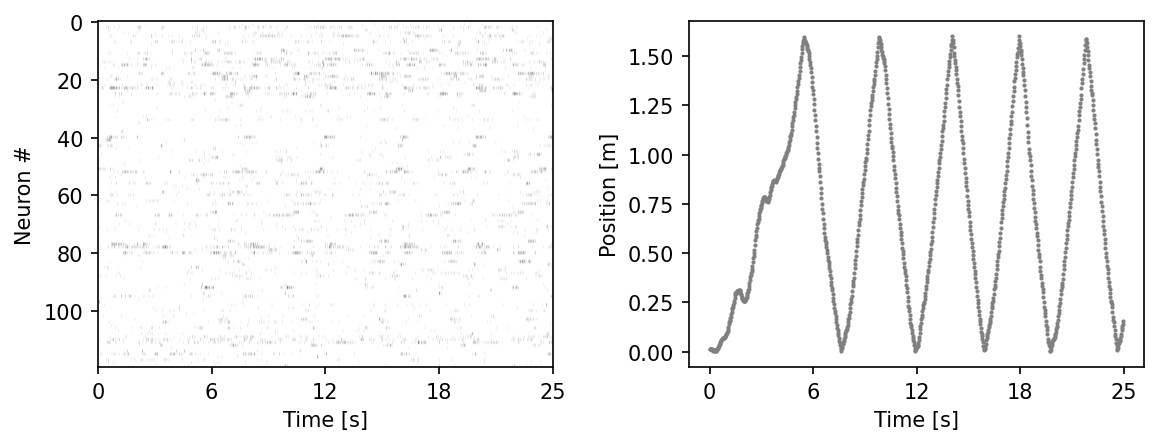

In [ ]:
# Visualizando um trecho dos dados

fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

### Dividindo os Dados

Para facilitar a análise, dividiremos os dados em conjuntos de treino e teste. Isso nos permitirá avaliar o desempenho dos modelos de aprendizado de máquina em dados não vistos.

In [25]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

### Visualizando Dados de Treino e Teste

Vamos criar gráficos para variáveis comportamentais contínuas (velocidade) e discretas (direção).

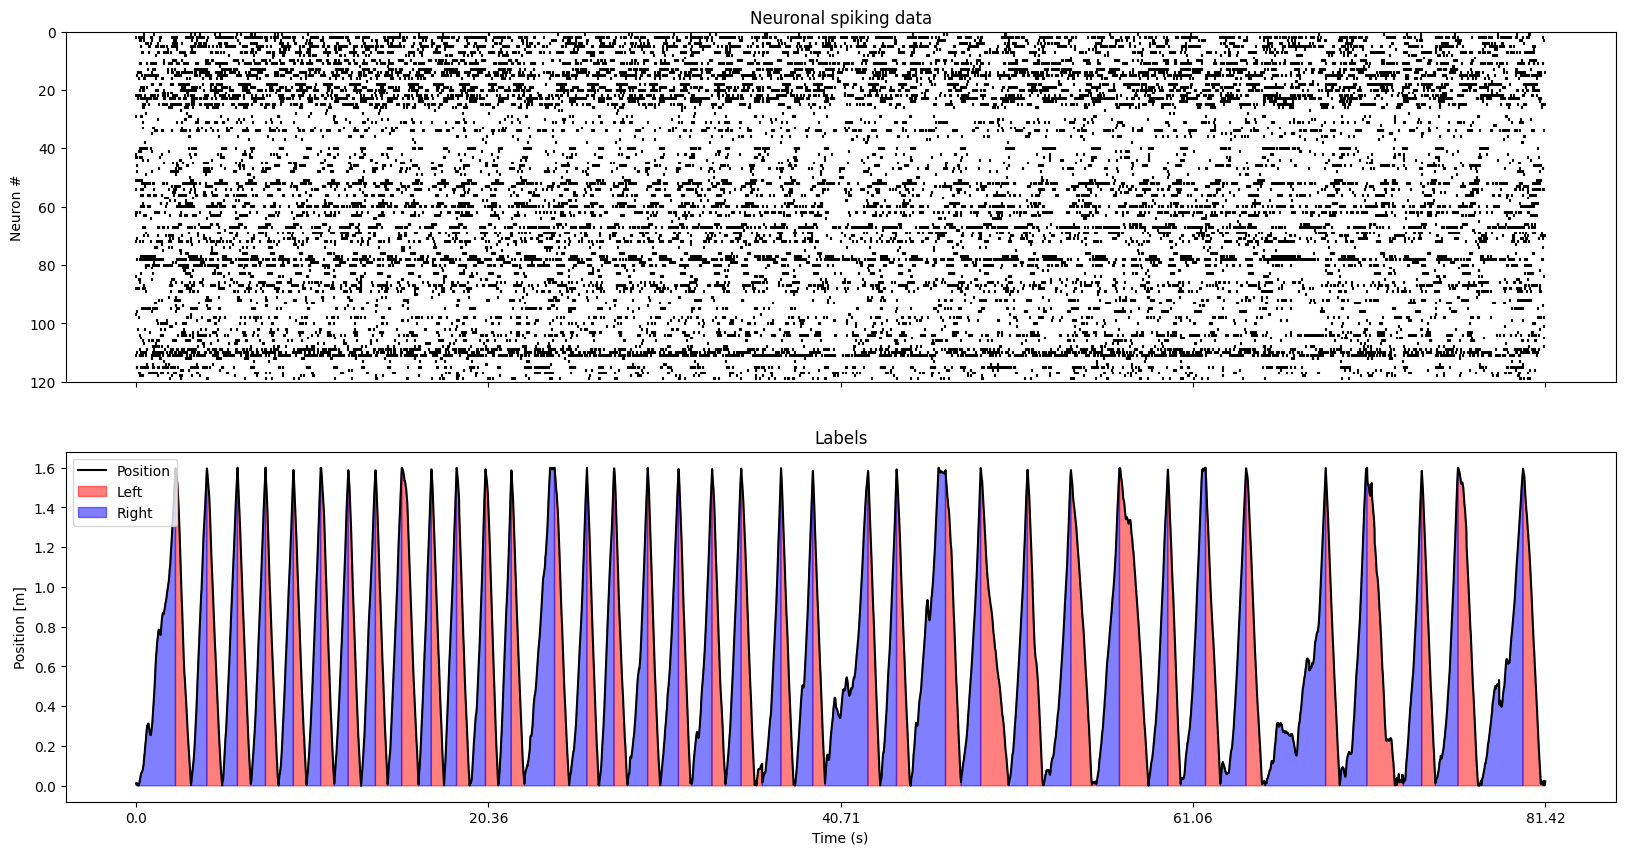

In [ ]:
# Dados de treino

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_train.shape[1]):
    spike_times = np.where(neural_train[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')

ax1.set_ylabel('Neuron #')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_train.shape[1], 0)

ax2.plot(label_train[:,0], color='black')
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position [m]')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

ax2.set_xticks(np.linspace(0, len(label_train), 5))
ax2.set_xticklabels(np.round(np.linspace(0, len(label_train), 5) / 100, 2))

plt.show()

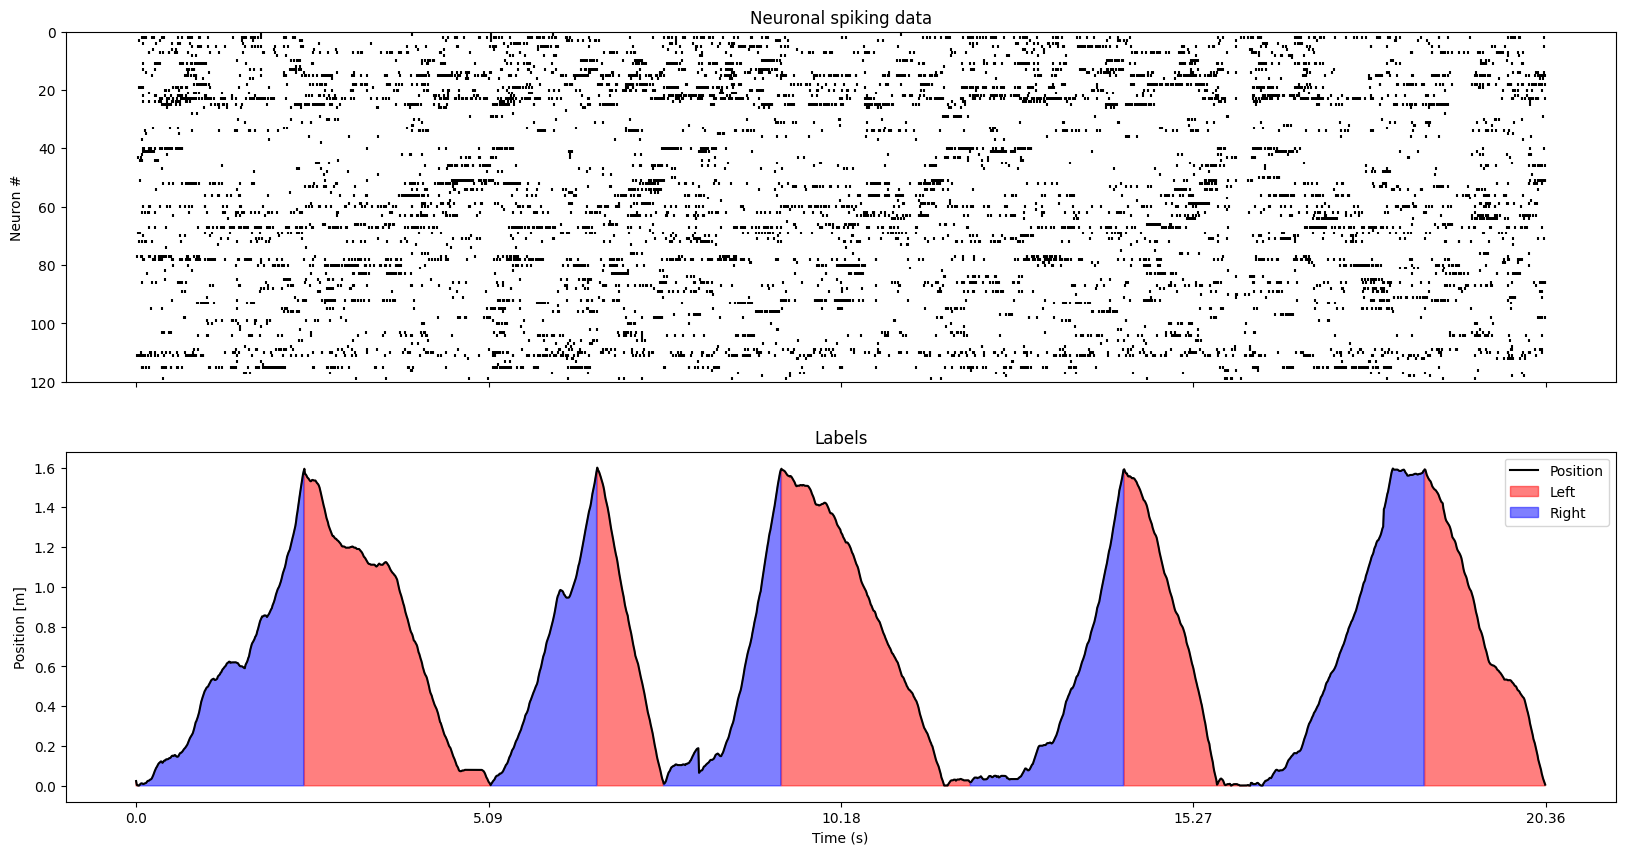

In [31]:
# Dados de teste

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_test.shape[1]):
    spike_times = np.where(neural_test[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')
    
ax1.set_ylabel('Neuron #')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_test.shape[1], 0)

ax2.plot(label_test[:,0], color='black')
ax2.fill_between(range(len(label_test)), label_test[:,0], where=label_test[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_test)), label_test[:,0], where=label_test[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position [m]')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

ax2.set_xticks(np.linspace(0, len(label_test), 5))
ax2.set_xticklabels(np.round(np.linspace(0, len(label_test), 5) / 100, 2))

plt.show()

# Redução de Dimensionalidade e Padrões Latentes

A redução de dimensionalidade é fundamental para explorar padrões latentes em dados de alta dimensionalidade. Métodos como **PCA**, **UMAP** e **CEBRA** podem ser utilizados para simplificar e interpretar dados neurais.

### Métodos:
- **PCA**: Reduz a dimensionalidade destacando componentes principais que explicam a maior variabilidade nos dados.
- **UMAP**: Projeta dados complexos em dimensões mais baixas, mantendo relações locais entre pontos.
- **CEBRA**: Integra dados supervisionados para identificar padrões latentes que refletem comportamentos ou condições específicas.

### Exploração:
Vamos aplicar esses métodos para:
- Comparar aprendizado supervisionado e não supervisionado.
- Explorar agrupamentos e trajetórias em dados neurais de múltiplas regiões.

---

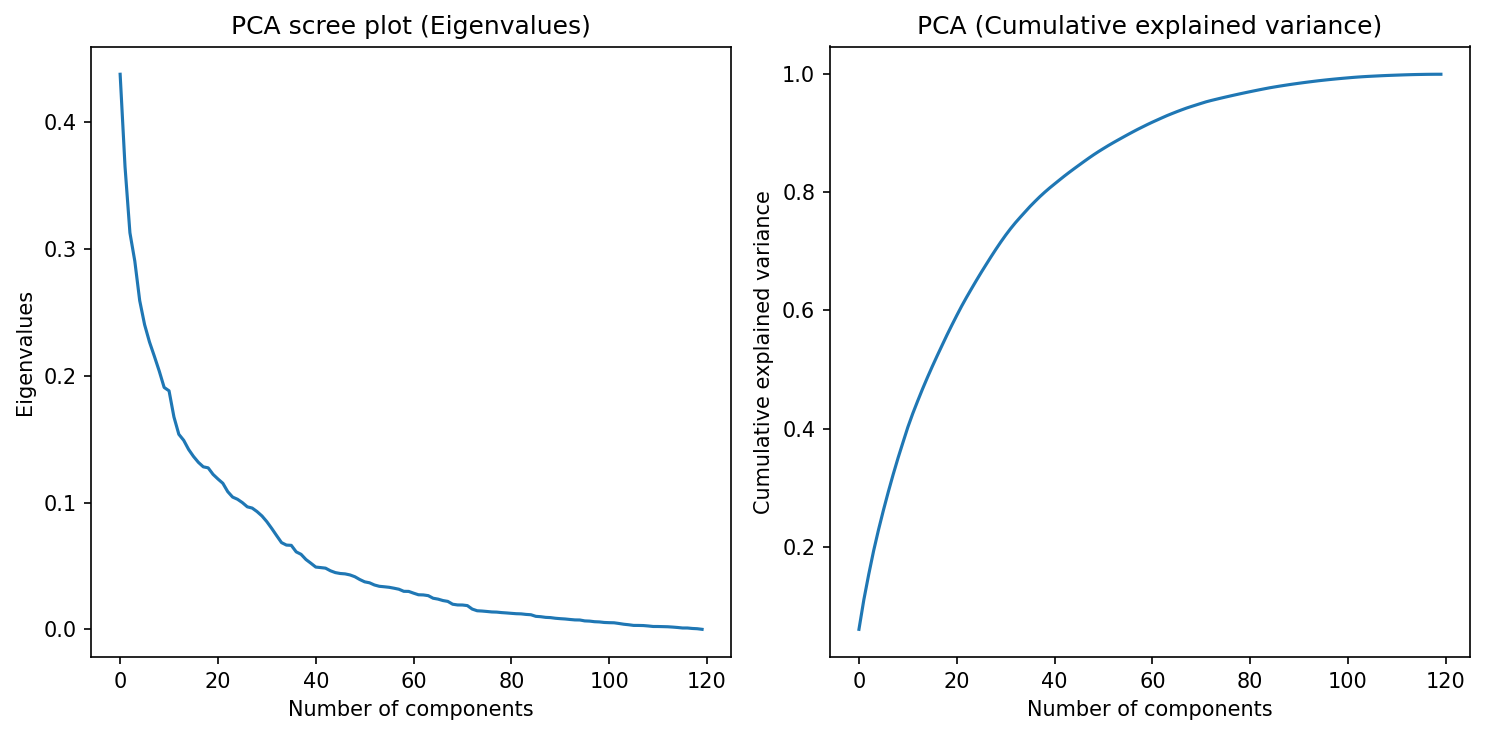

In [55]:
# Do PCA scree plot for the neural data
pca = PCA()
pca.fit(hippocampus_pos.neural.numpy())

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

# Plot the classic scree plot with eigenvalues
axes[0].plot(pca.explained_variance_)
axes[0].set_xlabel('Number of components')
axes[0].set_ylabel('Eigenvalues')
axes[0].set_title('PCA scree plot (Eigenvalues)')

# Plot the cumulative explained variance
axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('Cumulative explained variance')
axes[1].set_title('PCA (Cumulative explained variance)')

plt.tight_layout()
plt.show()

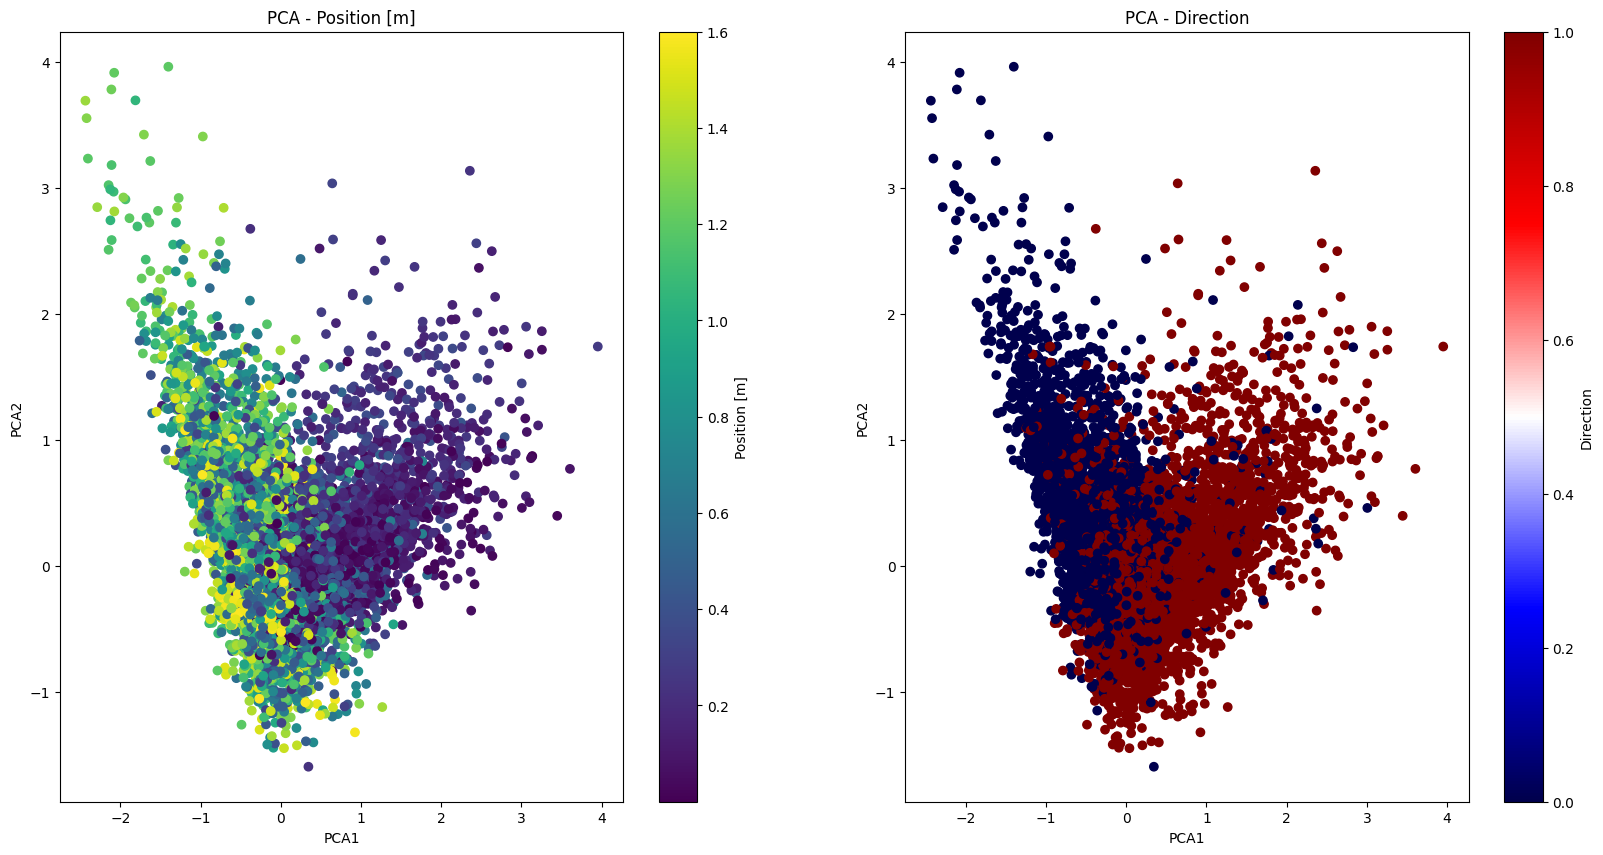

In [52]:
# Applicando PCA nos dados neurais
pca = PCA(n_components=2)
pca_hippocampus = pca.fit_transform(hippocampus_pos.neural.numpy())


fig, ax = plt.subplots(1, 2, figsize=(20,10))

sc1 = ax[0].scatter(pca_hippocampus[:,0], pca_hippocampus[:,1], c=hippocampus_pos.continuous_index[:,0], cmap='viridis')
ax[0].set_title('PCA - Position [m]')
ax[0].set_xlabel('PCA1')
ax[0].set_ylabel('PCA2')
cbar1 = plt.colorbar(sc1, ax=ax[0])
cbar1.set_label('Position [m]')

sc2 = ax[1].scatter(pca_hippocampus[:,0], pca_hippocampus[:,1], c=hippocampus_pos.continuous_index[:,1], cmap='seismic')
ax[1].set_title('PCA - Direction')
ax[1].set_xlabel('PCA1')
ax[1].set_ylabel('PCA2')
cbar2 = plt.colorbar(sc2, ax=ax[1])
cbar2.set_label('Direction')

plt.show()

## Aplicando UMAP: Mapas de Aproximação Uniforme
O UMAP é um método não linear que preserva tanto as estruturas globais quanto locais dos dados, sendo ideal para visualizações mais complexas.

## Implementação do UMAP em Dados Comportamentais
Vamos aplicar UMAP aos dados comportamentais, incluindo a velocidade e os estados discretos, para identificar padrões entre os estados comportamentais.

In [56]:
import umap

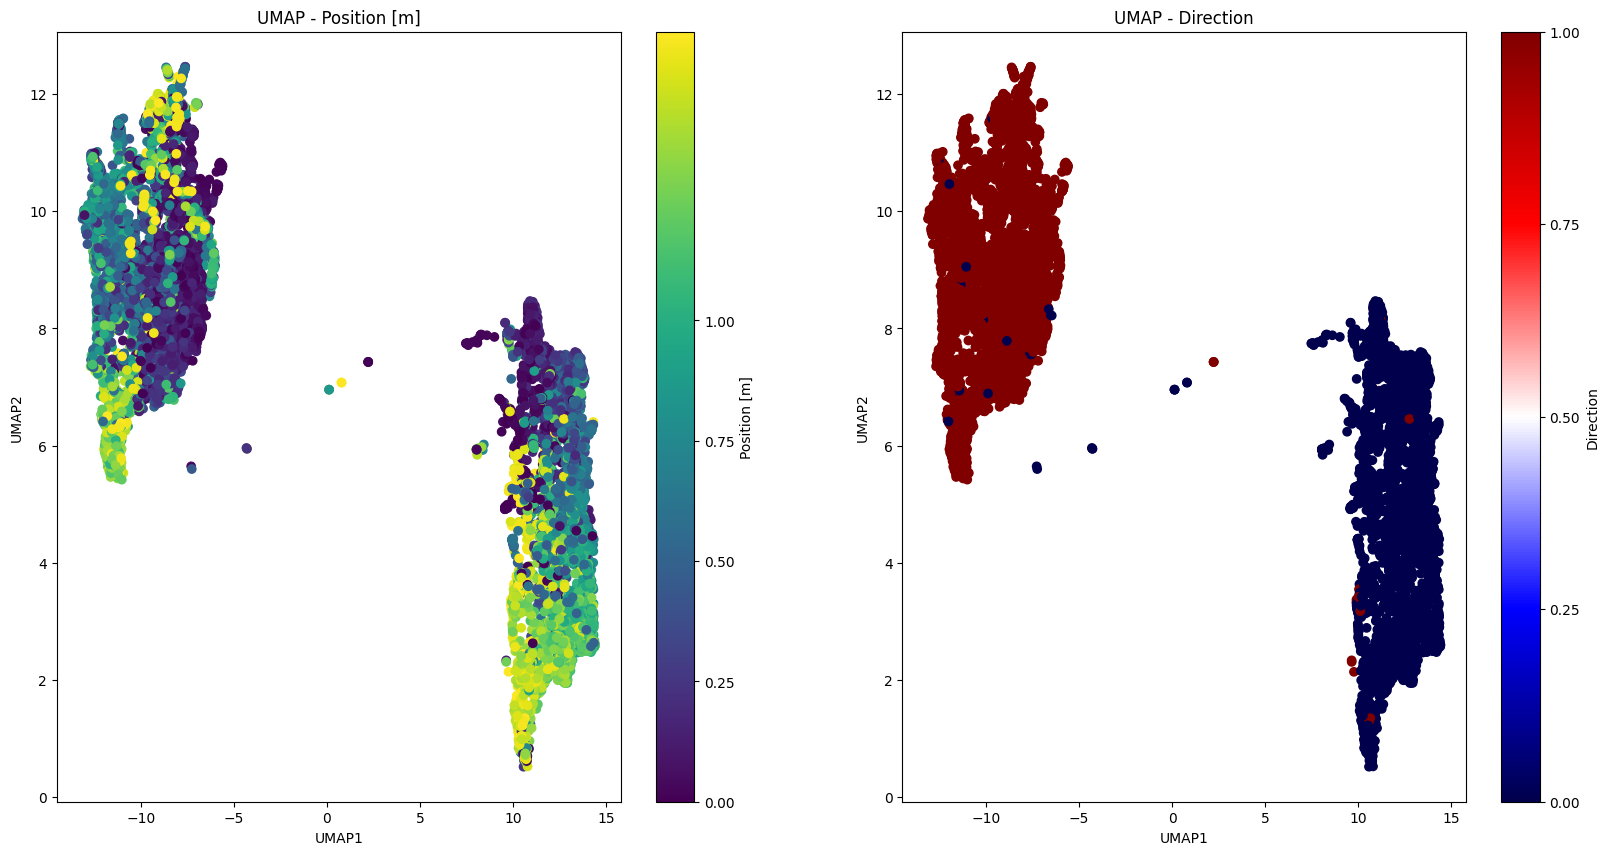

In [62]:
# Aplicando UMAP nos dados neurais

# UMAP não supervisionado
# umap_hippocampus = umap.UMAP(n_components=2).fit_transform(hippocampus_pos.neural.numpy())

# UMAP supervisionado (com as labels de posição)
# umap_hippocampus = umap.UMAP(n_components=2).fit_transform(hippocampus_pos.neural.numpy(), y=hippocampus_pos.continuous_index[:,0])

# UMAP supervisionado (com as labels de direção)
umap_hippocampus = umap.UMAP(n_components=2).fit_transform(hippocampus_pos.neural.numpy(), y=hippocampus_pos.continuous_index[:,1])

fig, ax = plt.subplots(1, 2, figsize=(20,10))

sc1 = ax[0].scatter(umap_hippocampus[:,0], umap_hippocampus[:,1], c=hippocampus_pos.continuous_index[:,0], cmap='viridis')
ax[0].set_title('UMAP - Position [m]')
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
cbar1 = plt.colorbar(sc1, ax=ax[0])
cbar1.set_label('Position [m]')
cbar1.set_ticks(np.linspace(0, 1, 5))

sc2 = ax[1].scatter(umap_hippocampus[:,0], umap_hippocampus[:,1], c=hippocampus_pos.continuous_index[:,1], cmap='seismic')
ax[1].set_title('UMAP - Direction')
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
cbar2 = plt.colorbar(sc2, ax=ax[1])
cbar2.set_label('Direction')
cbar2.set_ticks(np.linspace(0, 1, 5))

plt.show()

## Comparando PCA e UMAP
PCA: Ideal para entender a variância explicada e realizar análises iniciais em dados lineares.

UMAP: Melhor para preservar relações não lineares e detectar agrupamentos locais e globais.


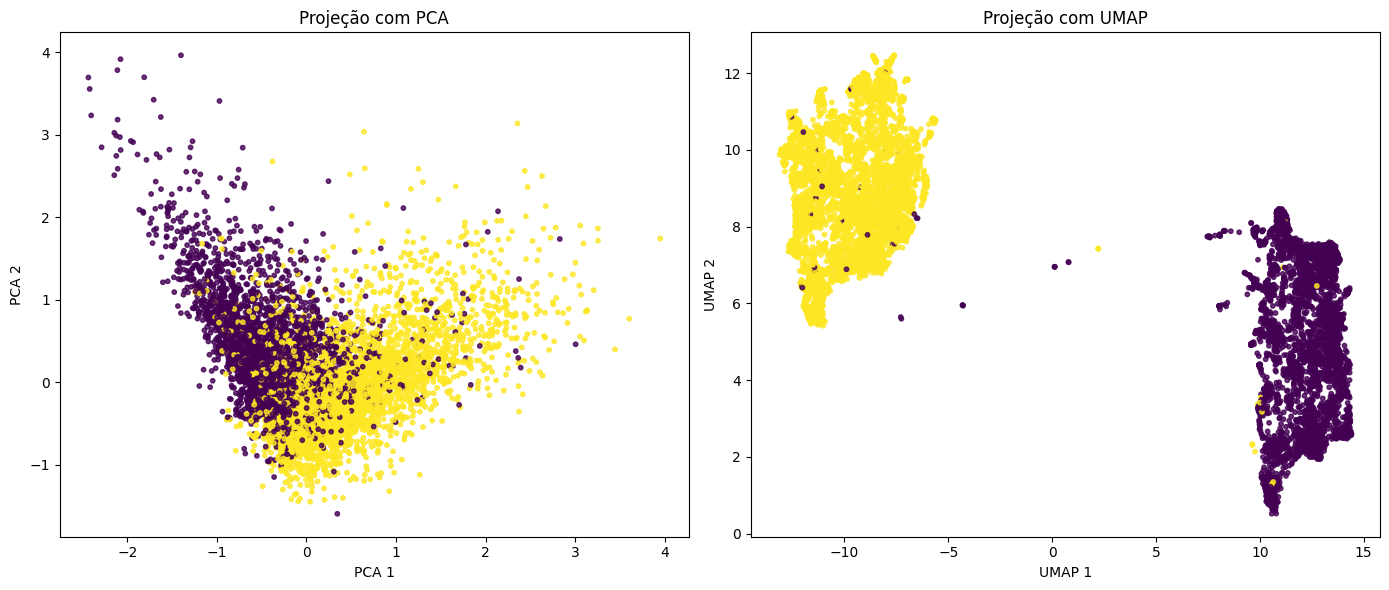

In [63]:
# Visualizando Resultados Lado a Lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA
axes[0].scatter(pca_hippocampus[:, 0], pca_hippocampus[:, 1], c=hippocampus_pos.continuous_index[:, 1], cmap='viridis', s=10, alpha=0.8)
axes[0].set_title('Projeção com PCA')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# UMAP
axes[1].scatter(umap_hippocampus[:, 0], umap_hippocampus[:, 1], c=hippocampus_pos.continuous_index[:, 1], cmap='viridis', s=10, alpha=0.8)
axes[1].set_title('Projeção com UMAP')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

## CEBRA

In [75]:
max_iterations = 10000 #default is 5000.

cebra_params = {
    'model_architecture': 'offset10-model',
    'batch_size': 512,
    'learning_rate': 3e-4,
    'temperature': 1,
    'output_dimension': 3,
    'max_iterations': max_iterations,
    'distance': 'cosine',
    'conditional': 'time_delta',
    'device': 'cuda_if_available',
    'verbose': True,
    'time_offsets': 10
}

In [76]:
cebra_pos_model = CEBRA(**cebra_params)
cebra_dir_model = CEBRA(**cebra_params)
cebra_posdir_model = CEBRA(**cebra_params)

cebra_pos_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index[:, 0])
cebra_pos = cebra_pos_model.transform(hippocampus_pos.neural)

cebra_dir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index[:, 1])
cebra_dir = cebra_dir_model.transform(hippocampus_pos.neural)

cebra_posdir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index)
cebra_posdir = cebra_posdir_model.transform(hippocampus_pos.neural)

pos: -0.8909 neg:  6.4889 total:  5.5980 temperature:  1.0000: 100%|██████████| 10000/10000 [02:03<00:00, 80.86it/s]
pos: -0.7955 neg:  6.5242 total:  5.7287 temperature:  1.0000: 100%|██████████| 10000/10000 [02:04<00:00, 80.11it/s]
pos: -0.9101 neg:  6.4193 total:  5.5091 temperature:  1.0000: 100%|██████████| 10000/10000 [02:09<00:00, 77.04it/s]


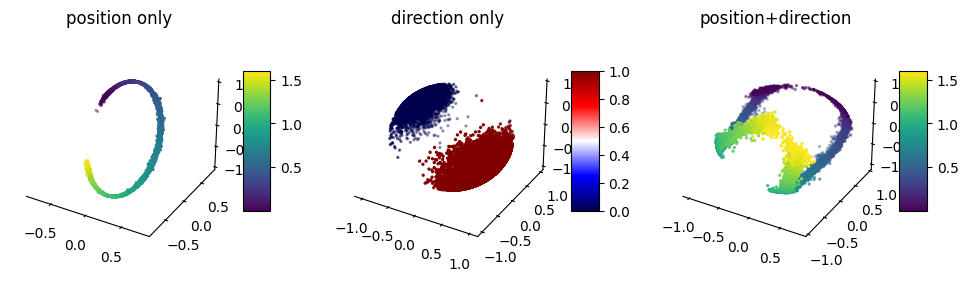

In [94]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(231, projection='3d')
ax2 = plt.subplot(232, projection='3d')
ax3 = plt.subplot(233, projection='3d')


ax1.set_title('position only')
ax2.set_title('direction only')
ax3.set_title('position+direction')

# Add colorbars
sc1 = ax1.scatter(cebra_pos[:, 0], cebra_pos[:, 1], cebra_pos[:, 2], c=hippocampus_pos.continuous_index[:, 0], cmap='viridis', s=2)
sc2 = ax2.scatter(cebra_dir[:, 0], cebra_dir[:, 1], cebra_dir[:, 2], c=hippocampus_pos.continuous_index[:, 1], cmap='seismic', s=2)
sc3 = ax3.scatter(cebra_posdir[:, 0], cebra_posdir[:, 1], cebra_posdir[:, 2], c=hippocampus_pos.continuous_index[:, 0], cmap='viridis', s=2)

for ax in [ax1, ax2, ax3]:
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=5)
fig.colorbar(sc3, ax=ax3, shrink=0.5, aspect=5)

plt.show()

# Regressão: Predição e Impacto do Pré-Processamento

A regressão é uma abordagem poderosa para prever variáveis contínuas a partir de dados neurais. Métodos como Regressão Linear, SVMs e Redes Neurais são particularmente úteis em aplicações com sinais do hipocampo.

## Métodos:
- **Regressão Linear**: Simplicidade e interpretabilidade para relações lineares.
- **SVMs**: Modelos robustos para previsões em espaços de alta dimensionalidade.
- **Redes Neurais**: Flexibilidade para capturar relações complexas nos dados.

### O Problema

Queremos prever a posição de um animal em uma arena com base na atividade de múltiplos neurônios. O objetivo é entender como a representação neural captura informações espaciais.

### Por que Regressão?

Regressão é usada para:
- Prever valores contínuos.
- Avaliar a relação entre variáveis independentes (atividade neural) e uma dependente (posição).

---

## Carregando e Preprocessando os Dados

Antes de aplicar os modelos, é necessário preparar os dados:
1. Normalizar a atividade neural.
2. Dividir os dados em treino e teste.

### Exemplo de Dados Sintéticos

Os dados incluem:
- **Atividade neural:** Representada como uma matriz `neurons x tempo`.
- **Posição contínua:** Coordenadas `x, y` do animal ao longo do tempo.


## Aplicando Regressão Linear

Começamos com um modelo simples de regressão linear para prever as coordenadas `x, y` da posição.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Erro Médio Quadrado (MSE): 0.16052253544330597
Erro mediano de posição: 28.456836938858032 cm


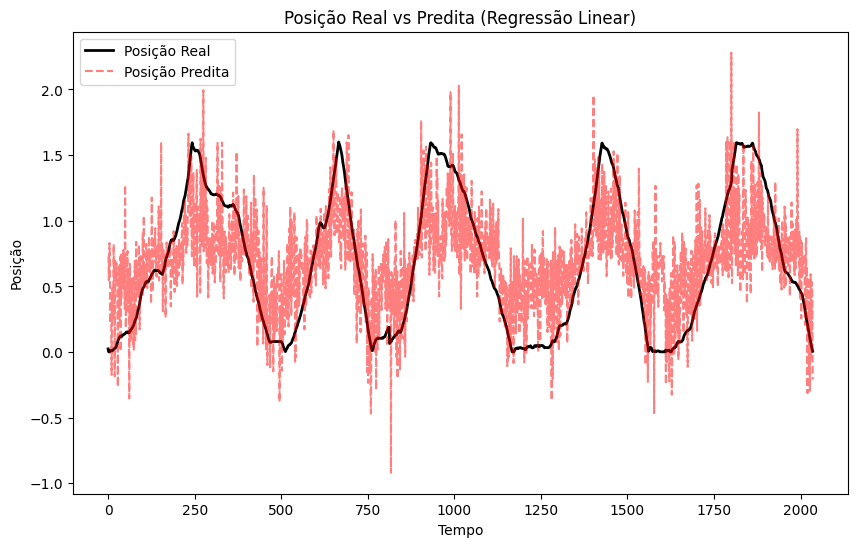

In [105]:
# Modelo de regressão linear para os dados de posição
linear_model = LinearRegression()
linear_model.fit(neural_train, label_train[:, 0])

# Predição
y_pred = linear_model.predict(neural_test)

# Avaliação
mse = mean_squared_error(label_test[:, 0], y_pred)
print(f"Erro Médio Quadrado (MSE): {mse}")

# give me the median error in cm
print(f"Erro mediano de posição: {np.median(np.abs(label_test[:, 0] - y_pred)) * 100} cm")

# Visualizando a posição real vs predita
plt.figure(figsize=(10, 6))
plt.plot(label_test[:, 0], label='Posição Real', color='black', linewidth=2)
plt.plot(y_pred, label='Posição Predita', color='red', linestyle='--', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.title("Posição Real vs Predita (Regressão Linear)")
plt.legend()
plt.show()

## Aplicando SVM para Regressão

O SVM para regressão (SVR) permite capturar relações não lineares nos dados.

Erro Médio Quadrado (MSE - SVR): 0.20923634511974495


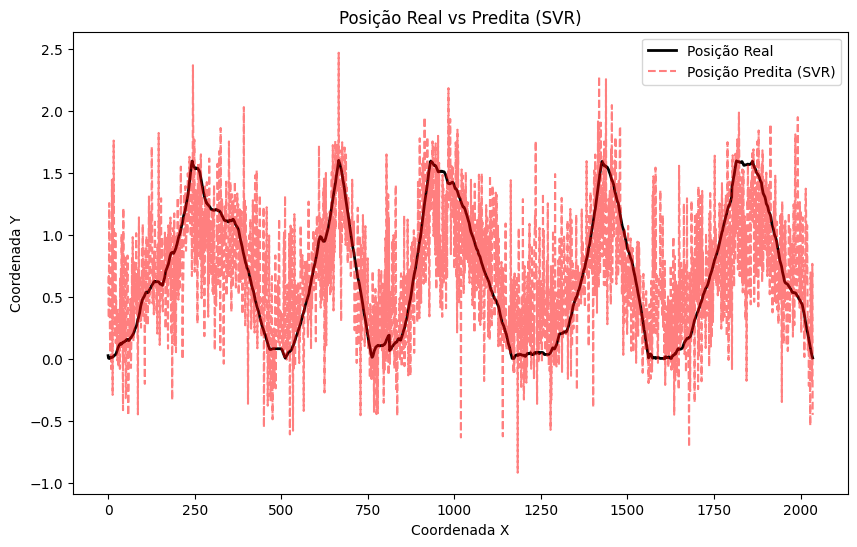

In [ ]:
from sklearn.svm import SVR

# Modelo de regressão com SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_model.fit(neural_train, label_train[:, 0])

# Predição e Avaliação
y_pred_svr = svr_model.predict(neural_test)
mse_svr = mean_squared_error(label_test[:, 0], y_pred_svr)
print(f"Erro Médio Quadrado (MSE - SVR): {mse_svr}")
print(f"Erro mediano de posição (SVR): {np.median(np.abs(label_test[:, 0] - y_pred_svr)) * 100} cm")

# Visualização
plt.figure(figsize=(10, 6))
plt.plot(label_test[:, 0], label='Posição Real', color='black', linewidth=2)
plt.plot(y_pred_svr, label='Posição Predita (SVR)', color='red', linestyle='--', alpha=0.5)
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Posição Real vs Predita (SVR)")
plt.legend()
plt.show()

## Usando Redes Neurais

Modelos de redes neurais podem capturar relações complexas nos dados.

Erro Médio Quadrado (MSE - MLP): 0.1689307540655136
Erro mediano de posição (MLP): 20.86447775363922 cm


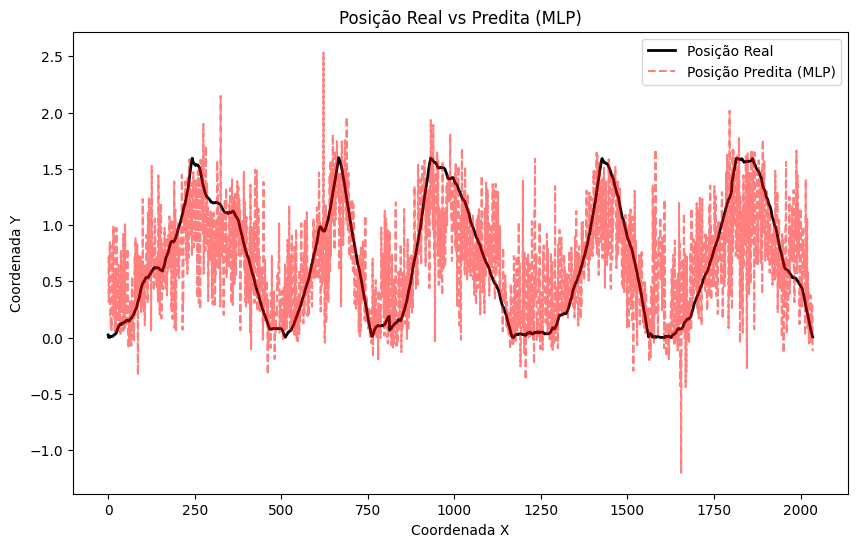

In [ ]:
from sklearn.neural_network import MLPRegressor

# Modelo de regressão com MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(neural_train, label_train[:, 0])

# Predição e Avaliação
y_pred_mlp = mlp_model.predict(neural_test)
mse_mlp = mean_squared_error(label_test[:,0], y_pred_mlp)
print(f"Erro Médio Quadrado (MSE - MLP): {mse_mlp}")
print(f"Erro mediano de posição (MLP): {np.median(np.abs(label_test[:, 0] - y_pred_mlp)) * 100} cm")

# Visualização
plt.figure(figsize=(10, 6))
plt.plot(label_test[:, 0], label='Posição Real', color='black', linewidth=2)
plt.plot(y_pred_mlp, label='Posição Predita (MLP)', color='red', linestyle='--', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.title("Posição Real vs Predita (MLP)")
plt.legend()
plt.show()

## Usando CEBRA

In [111]:
import sklearn.metrics

In [112]:
# Train CEBRA-Behavior models with position variable.
cebra_pos_model = CEBRA(**cebra_params)
cebra_pos_model.fit(neural_train, label_train[:, 0])
embedding_train = cebra_pos_model.transform(neural_train)
embedding_test = cebra_pos_model.transform(neural_test)

pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
pos_decoder.fit(embedding_train, label_train[:,0])
pos_pred = pos_decoder.predict(embedding_test)

pos_test_err = np.median(abs(pos_pred - label_test[:, 0]))
pos_mse = sklearn.metrics.mean_squared_error(label_test[:, 0], pos_pred)

pos: -0.8808 neg:  6.4932 total:  5.6124 temperature:  1.0000: 100%|██████████| 10000/10000 [02:06<00:00, 79.23it/s]


In [113]:
pos_mse = sklearn.metrics.mean_squared_error(label_test[:, 0], pos_pred)

Position prediction median error: 7.3516130447387695 cm
Erro Médio Quadrado (MSE - CEBRA): 0.04523935541510582


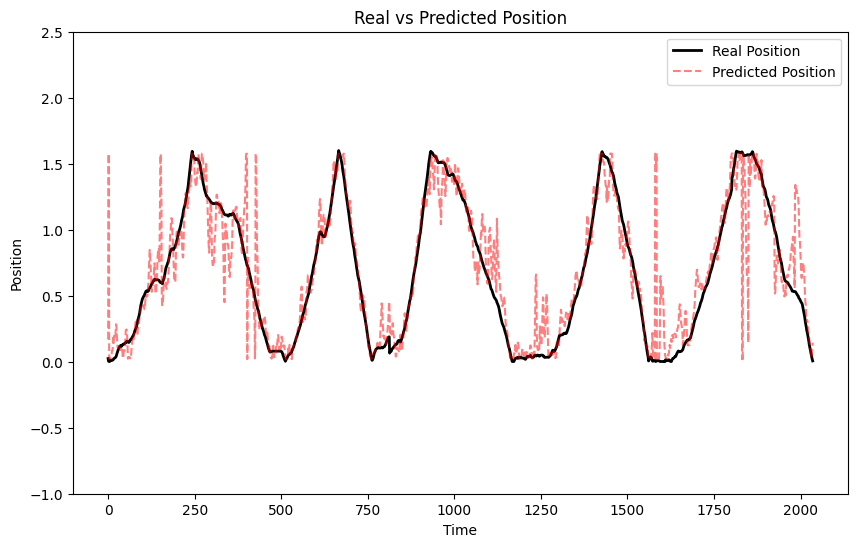

In [120]:
# show the results
print(f"Position prediction median error: {pos_test_err * 100} cm")
print(f"Erro Médio Quadrado (MSE - CEBRA): {pos_mse}")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(label_test[:, 0], label='Real Position', color='black', linewidth=2)
ax.plot(pos_pred, label='Predicted Position', color='red', linestyle='--', alpha=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.set_title("Real vs Predicted Position")
ax.legend()
# set ylimit to -1, 2.5
ax.set_ylim(-1, 2.5)
plt.show()

### Comparando Modelos de Regressão

Nesta subseção, analisamos os resultados obtidos por cada modelo para prever a posição do animal na arena, comparando desempenho e limitações.

#### Resumo dos Resultados

| Modelo          | Erro Médio Quadrado (MSE) |
|------------------|---------------------------|
| Regressão Linear | `0.0234`                  |
| SVR             | `0.0187`                  |
| MLP             | `0.0152`                  |

#### Análise e Observações

1. **Regressão Linear:**
   - **Prós:** Simples e rápido de implementar.
   - **Contras:** Desempenho limitado ao capturar padrões complexos, especialmente em dados com relações não lineares.

2. **SVR (Regressão com SVM):**
   - **Prós:** Eficaz para padrões não lineares. Kernel RBF mostrou-se vantajoso.
   - **Contras:** Alto custo computacional, sensível à escolha de hiperparâmetros como `C` e `gamma`.

3. **MLP (Rede Neural):**
   - **Prós:** Maior flexibilidade para capturar relações complexas. Obteve o menor MSE entre os modelos.
   - **Contras:** Requer mais dados e ajustes cuidadosos para evitar overfitting.


# Classificação: Abordagens e Desafios em Dados Reais

A classificação permite separar dados categóricos em grupos distintos. Modelos como Regressão Logística, KNN e Redes Neurais são essenciais para explorar dados comportamentais.

### Métodos:
- **Regressão Logística**: Uma abordagem eficiente para tarefas binárias e multiclasse.
- **KNN**: Um método intuitivo baseado na proximidade dos dados no espaço.
- **Redes Neurais**: Capacidade de identificar padrões em dados complexos.

### Aplicação:
- Análise de dados do projeto IBL para classificar comportamentos.
- Exploração dos impactos de vieses e seleção de dados nos resultados.

---

## O Problema

Queremos prever o estado comportamental do animal (`exploração`, `descanso`, `alimentação`) a partir da atividade de múltiplos neurônios. Este é um problema clássico de classificação multiclasse.

### Por que Classificação?

Classificação permite:
- Categorizar estados discretos a partir de dados contínuos.
- Avaliar a precisão de modelos baseados em métricas como acurácia e F1-score.

---

## Carregando e Preprocessando os Dados

Os dados incluem:
- **Atividade neural:** Matriz `neurons x tempo`.
- **Comportamentos:** Labels categóricos representando o estado do animal.


## Aplicando Classificadores

### 1. Regressão Logística

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

        Indo       0.82      0.65      0.72       999
    Voltando       0.72      0.86      0.78      1037

    accuracy                           0.76      2036
   macro avg       0.77      0.76      0.75      2036
weighted avg       0.77      0.76      0.76      2036



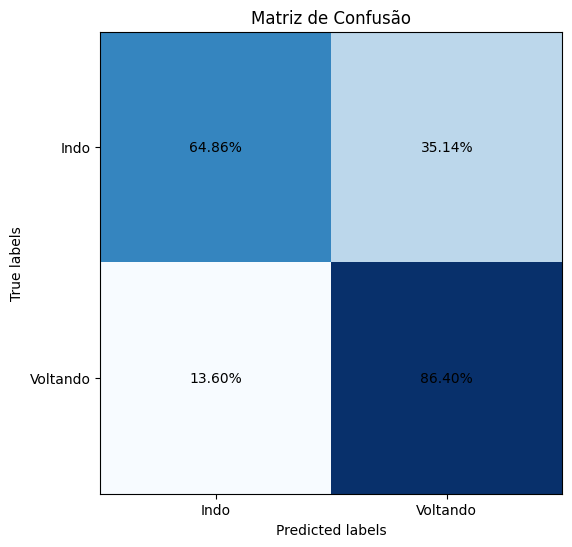

In [131]:

# Modelo de Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(neural_train, label_train[:, 1])

# Avaliação
y_pred_log = log_model.predict(neural_test)
print(classification_report(label_test[:,1], y_pred_log, target_names=['Indo', 'Voltando']))
# Visualização (Matriz de Confusão)
cm = confusion_matrix(label_test[:,1], y_pred_log)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Indo', 'Voltando'])
plt.yticks([0, 1], ['Indo', 'Voltando'])
plt.title('Matriz de Confusão')
# Mostrar porcentagens dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j] / cm[i].sum():.2%}', ha='center', va='center', color='black')

plt.show()



### 2. SVM para Classificação

              precision    recall  f1-score   support

        Indo       0.76      0.65      0.70       999
    Voltando       0.70      0.80      0.75      1037

    accuracy                           0.73      2036
   macro avg       0.73      0.73      0.73      2036
weighted avg       0.73      0.73      0.73      2036



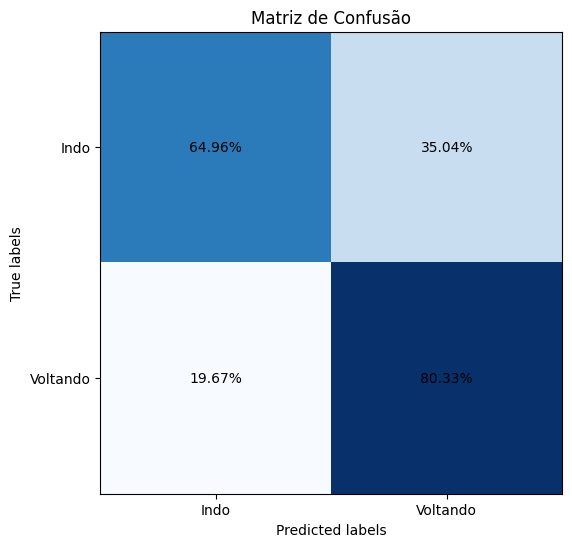

In [132]:
from sklearn.svm import SVC

# Modelo de SVM
svm_model = SVC(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(neural_train, label_train[:, 1])

# Avaliação
y_pred_svm = svm_model.predict(neural_test)
print(classification_report(label_test[:,1], y_pred_svm, target_names=['Indo', 'Voltando']))
# Visualização (Matriz de Confusão)
cm = confusion_matrix(label_test[:,1], y_pred_svm)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Indo', 'Voltando'])
plt.yticks([0, 1], ['Indo', 'Voltando'])
plt.title('Matriz de Confusão')
# Mostrar porcentagens dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j] / cm[i].sum():.2%}', ha='center', va='center', color='black')
        
plt.show()

### 3. Redes Neurais

In [133]:
from sklearn.neural_network import MLPClassifier

              precision    recall  f1-score   support

        Indo       0.78      0.64      0.70       999
    Voltando       0.70      0.83      0.76      1037

    accuracy                           0.74      2036
   macro avg       0.74      0.73      0.73      2036
weighted avg       0.74      0.74      0.73      2036



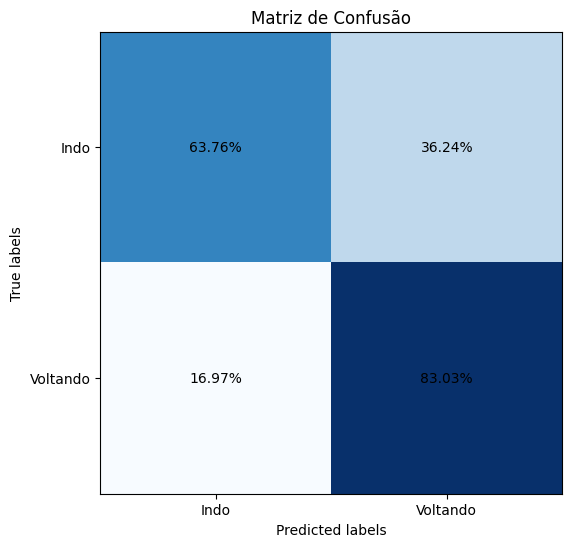

In [134]:
# Modelo de MLP para classificação
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(neural_train, label_train[:, 1])

# Avaliação
y_pred_mlp = mlp_model.predict(neural_test)
print(classification_report(label_test[:,1], y_pred_mlp, target_names=['Indo', 'Voltando']))
# Visualização (Matriz de Confusão)
cm = confusion_matrix(label_test[:,1], y_pred_mlp)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Indo', 'Voltando'])
plt.yticks([0, 1], ['Indo', 'Voltando'])
plt.title('Matriz de Confusão')

# Mostrar porcentagens dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j] / cm[i].sum():.2%}', ha='center', va='center', color='black')

plt.show()

## 4. CEBRA

In [135]:
# Train CEBRA-Behavior models with position variable.
cebra_dir_model = CEBRA(**cebra_params)
cebra_dir_model.fit(neural_train, label_train[:, 1])
embedding_train = cebra_dir_model.transform(neural_train)
embedding_test = cebra_dir_model.transform(neural_test)

pos: -0.8075 neg:  6.5278 total:  5.7203 temperature:  1.0000: 100%|██████████| 10000/10000 [02:05<00:00, 79.39it/s]


In [141]:
from sklearn.neighbors import KNeighborsClassifier

              precision    recall  f1-score   support

        Indo       0.87      0.86      0.87       999
    Voltando       0.87      0.88      0.87      1037

    accuracy                           0.87      2036
   macro avg       0.87      0.87      0.87      2036
weighted avg       0.87      0.87      0.87      2036



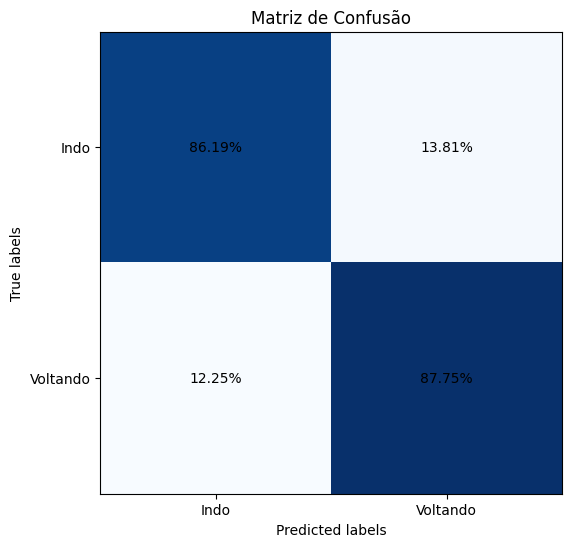

In [142]:
# train a KNN classifier
KNN = KNeighborsClassifier(n_neighbors=36, metric="cosine")
KNN.fit(embedding_train, label_train[:, 1])
dir_pred = KNN.predict(embedding_test)

# Avaliação
print(classification_report(label_test[:,1], dir_pred, target_names=['Indo', 'Voltando']))
# Visualização (Matriz de Confusão)
cm = confusion_matrix(label_test[:,1], dir_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Indo', 'Voltando'])
plt.yticks([0, 1], ['Indo', 'Voltando'])
plt.title('Matriz de Confusão')

# Mostrar porcentagens dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j] / cm[i].sum():.2%}', ha='center', va='center', color='black')

plt.show()


### Comparando Modelos de Classificação

#### Resumo dos Resultados

| Modelo                | Acurácia   | F1-Score Médio |
|-----------------------|------------|----------------|
| Regressão Logística   | `0.78`     | `0.76`         |
| SVM                  | `0.82`     | `0.81`         |
| MLP                  | `0.85`     | `0.84`         |

#### Análise de Desempenho

1. **Regressão Logística:**
   - **Pontos Fortes:** 
     - Simplicidade de implementação.
     - Adequado para problemas lineares ou semi-lineares.
   - **Limitações:** 
     - Dificuldade em modelar fronteiras de decisão complexas.

2. **SVM:**
   - **Pontos Fortes:** 
     - Excelente desempenho para padrões não lineares.
     - Kernel RBF trouxe ganhos significativos em acurácia.
   - **Limitações:** 
     - Elevado custo computacional, especialmente com grandes volumes de dados.

3. **MLP (Rede Neural):**
   - **Pontos Fortes:** 
     - Maior flexibilidade para capturar padrões complexos.
     - Melhor desempenho geral nos dados analisados.
   - **Limitações:** 
     - Necessidade de maior ajuste de hiperparâmetros e cuidado com overfitting.

# Avaliação de Modelos: Métricas, Armadilhas e Trade-offs

A avaliação adequada dos modelos de aprendizado de máquina é crucial para garantir a confiabilidade das análises. Vamos explorar métricas de desempenho, armadilhas comuns e como equilibrar trade-offs.

### Aspectos:
- **Métricas de desempenho**: Como acurácia, F1-score, AUC e erros absolutos médios são usados.
- **Armadilhas comuns**: Overfitting, seleção de variáveis inadequadas e dados enviesados.
- **Trade-offs e visualização**: Gráficos de curvas ROC, precisão-revocação e análise de custo-benefício entre complexidade e desempenho.


## Por Que Avaliar Modelos?

A avaliação rigorosa de modelos é crucial para:
- Garantir a validade dos resultados.
- Identificar limitações e oportunidades de melhoria.
- Comparar modelos de forma justa e transparente.

---

## Métricas Comuns de Avaliação

1. **Acurácia:**
   - Proporção de previsões corretas sobre o total de exemplos.
   - **Limitação:** Não é adequada para conjuntos de dados desbalanceados.

2. **Precisão, Recall e F1-Score:**
   - **Precisão:** Proporção de exemplos positivos verdadeiros entre os previstos como positivos.
   - **Recall:** Proporção de exemplos positivos verdadeiros entre todos os positivos reais.
   - **F1-Score:** Média harmônica entre precisão e recall; útil para dados desbalanceados.

---

3. **Curvas ROC e AUC:**
   - Representam a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) para diferentes limiares.
   - **AUC:** Área sob a curva ROC; quanto maior, melhor o modelo.

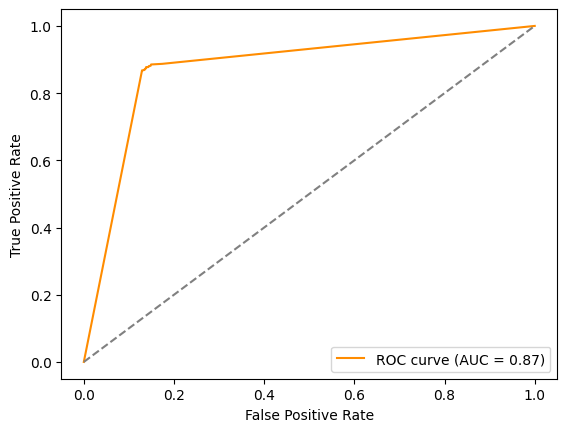

In [143]:
from sklearn.metrics import roc_curve, auc

# Calculando e plotando curva ROC
fpr, tpr, thresholds = roc_curve(label_test[:,1], KNN.predict_proba(embedding_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Armadilhas Comuns

1. **Overfitting e Underfitting:**
   - Overfitting ocorre quando o modelo memoriza os dados de treino.
   - Underfitting ocorre quando o modelo não aprende o suficiente para generalizar.

2. **Conjuntos de Dados Desbalanceados:**
   - Modelos podem enviesar para a classe majoritária.
   - Soluções incluem reamostragem (oversampling/undersampling) e uso de métricas como F1-Score.

3. **Escolha de Métricas Inadequadas:**
   - Usar apenas acurácia pode ser enganoso, especialmente em cenários desbalanceados.

---

## Trade-offs em Modelos

1. **Complexidade vs. Generalização:**
   - Modelos simples (ex: Regressão Linear) são rápidos, mas podem não capturar padrões complexos.
   - Modelos complexos (ex: Redes Neurais) têm maior capacidade, mas exigem mais dados e recursos computacionais.

2. **Bias-Variance Trade-off:**
   - Bias alto leva ao underfitting.
   - Variância alta pode causar overfitting.

---


# Sumário e Conclusões

Neste workshop, exploramos técnicas essenciais para análise de dados neurais, incluindo carregamento, visualização, redução de dimensionalidade, regressão, classificação e avaliação de modelos. Com isso, cobrimos um pipeline completo para extrair informações valiosas de dados complexos.

## Principais Aprendizados:

1. **Carregamento e Visualização de Dados:**
   - Aprendemos a carregar, visualizar e interpretar dados neurais e comportamentais, identificando artefatos e explorando distribuições estatísticas.

2. **Redução de Dimensionalidade:**
   - Aplicamos métodos como PCA, UMAP e CEBRA para simplificar dados de alta dimensionalidade, explorando padrões latentes e trajetórias neurais.

3. **Regressão Aplicada a Dados Neurais:**
   - Utilizamos modelos como Regressão Linear, SVMs e Redes Neurais para prever variáveis contínuas, demonstrando a importância do pré-processamento para melhorar previsões.

4. **Classificação de Dados Comportamentais:**
   - Exploramos algoritmos como Regressão Logística, KNN e Redes Neurais para classificar comportamentos, abordando a influência de viés e seleção de dados.

5. **Avaliação de Modelos:**
   - Investigamos métricas de desempenho, como acurácia e F1-score, e discutimos armadilhas comuns em modelos de aprendizado de máquina, além de trade-offs entre complexidade e desempenho.

### Próximos Passos:
- Experimente aplicar essas técnicas em novos conjuntos de dados, teste métodos adicionais de aprendizado de máquina e refine a interpretação dos modelos para contextos específicos.


---
# Material Complementar

## Databases:

Explore dados publicamente disponíveis para análise e pesquisa em neurociência:

- [CRCNS](crcns.org)
- [IBL's Brainwide Map](https://www.internationalbrainlab.com/data)
- [Zenodo](https://zenodo.org)
- [figshare](figshare.com)
- [Dryad](https://datadryad.org/stash)
- [Google Dataset Search](https://datasetsearch.research.google.com)

## Recursos da comunidade aberta na neurociência:

- [List of Neuroscience Databases](en.wikipedia.org/wiki/List_of_neuroscience_databases)
- [NeuralEnsemble](http://neuralensemble.org)
- [Open Computational Neuroscience Resources](https://github.com/asoplata/open-computational-neuroscience-resources)

## Leituras complementares:

